# Detecting Anomalous Event Sequences with Temporal Point Processes (NeurIPS2021読み会)

- 論文へのリンク: [2106.04465.pdf (arxiv.org)](https://arxiv.org/pdf/2106.04465.pdf)
- 筆者・所属機関: [[Oleksandr Shchur]], [[Ali Caner Turkmen]], [[Tim Januschowski]], [[Jan Gasthaus]], [[Stephan Günnemann]]
- 投稿日付: 2021/8/8
- 投稿誌・学会: [[NeurIPS]] 2021
- 実装: [shchur/tpp-anomaly-detection (github.com)](https://github.com/shchur/tpp-anomaly-detection)

## 概要
時間点過程(Temporal Point Process, TPP)におけるOOD検知のための新しい評価指標の提案論文。
一般的なGoodness-of-Fit test（適合度検定）をTPPに使う問題点を示し、様々なTPPモデルに使える簡便な新しい指標を提案。実データ実験も実施。

## そもそも（時間）点過程とは
空間/時系列上のランダムに分布する点（イベント）の集合に関する確率過程
興味の対象： イベント間隔や発生タイミング

例えば、
- 地震の発生
- 金融取引
- SNSでの投稿

ある観察期間$[0, T]$ の全部で$n$個のイベントが発生したとき、それぞれのイベントの発生時刻を$t_i, (i=1, 2, \cdots, n)$で表し、それらの集合（イベント系列）を$\boldsymbol{t}_n = \{t_1, t_2, \cdots, t_n \}$で表す。ただし、$t_1<t_2<\cdots<t_n$。
イベント間間隔を$\tau_i=t_{i+1}-t_i$で表す。
イベントが発生する時刻にはランダム性が伴っており、イベント系列を確率的なプロセスとして扱う。

![](fig/fig1.jpg)

マーク付き点過程: イベント発生時刻だけでなく付加的な情報を持っている場合（地震の発生時刻+震度/場所など）


### 強度関数
イベントの発生しやすさを**強度（intensity）$\lambda$** として定義。強度が時間変化する時には、強度関数（intensity function）として表される。さらに過去のイベント履歴や付随する情報に依存する場合には条件付き強度関数によって表される。

### 定常ポアソン過程
強度関数が時間に依存せず　$\lambda(t)=\lambda$ で一定な過程.

- 各イベントの発生は独立
- イベント間間隔 $\tau$ は期待値$1/\lambda$, 分散$1/\lambda^2$の指数分布に従う
- イベント発生回数$n$ は期待値$\lambda T$, 分散$\lambda T$のポアソン分布に従う

**イベント系列の確率密度関数（同時分布）**

$$
p(\mathbb t_n)= \lambda^n \exp [-\lambda T]
$$

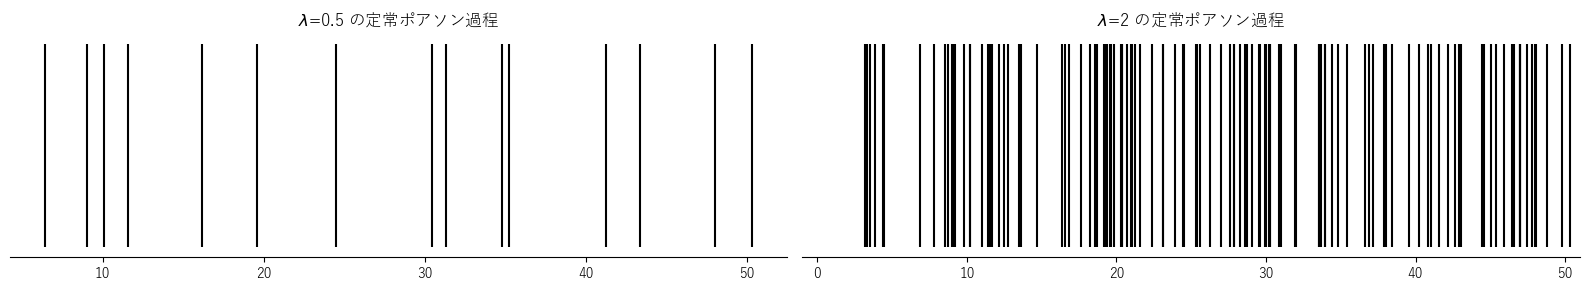

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
rg = np.random.default_rng()

def poisson_process(lam, max_t):
    # 1/beta exp(-1/beta x) のbetaが引数. lambda = 1/beta
    last = np.random.exponential(scale=1/lam)
    events = [last]

    while last <= max_t:
        wait_time = np.random.exponential(scale=1/lam)
        last += wait_time
        events.append(last)
    return events


fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)

for i, l in enumerate([0.5, 2]):
    ax = axes[i]
    ax.vlines(poisson_process(l, max_t=50), 0, 1)
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_title(f'$\lambda$={l} の定常ポアソン過程')
plt.xlim([-1, 51])
# plt.tick_params(left=False, right=False, top=False)
plt.tight_layout()

# plt.savefig('spoisson.png')
plt.show()

### 非定常ポアソン過程

強度関数$\lambda(t)$が時間依存で変化する過程。

観察期間$[0, T]$における、強度関数$\lambda(t)$の非定常ポアソン分布の確率密度関数

$$
p(\mathbb t_n) = \prod_{i=1}^n \lambda(t_i) \times \exp \left[ -\int_0^T \lambda(t)dt \right]
$$

- イベント発生数は期待値$\Lambda(T)=\int_0^T\lambda(t)dt$のポアソン分布に従う

### 数値計算例

棄却法をもちいたシミュレーション

- 青い曲線: 強度関数
- 上部の黒いバー：　イベント発生時刻
- 青○：候補点のうち採用されたもの（強度関数の曲線より採択比率が下の時採用）
- オレンジ×：候補点のうち不採用のもの

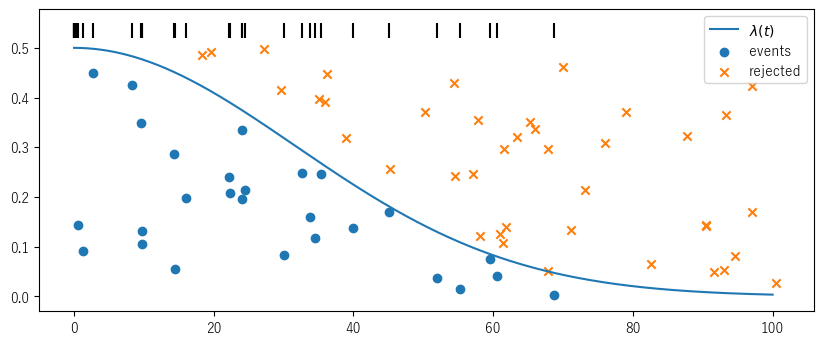

In [2]:
lam = 1/2.0

last = 0
events = []
rejected = []
window = 100

def proposal(t):
    return 1/2*np.exp(-0.0005*t**2)

while last <= window:
    wait_time = np.random.exponential(scale=1/lam)
    last += wait_time           # イベント候補時刻
    r = proposal(last) / lam  # 採択比率
    u = np.random.uniform()
    if u <= r:
        events.append([last, u*lam])
    else:
        rejected.append([last, u*lam])

events = np.array(events)
rejected = np.array(rejected)

x = np.linspace(0, 100, num=1000)
y = 1/2*np.exp(-0.0005*x**2)

fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_subplot()
ax.plot(x, y, label='$\lambda(t)$')
ax.scatter(events[:, 0], events[:, 1], label='events')
ax.scatter(rejected[:, 0], rejected[:, 1], marker='x', label='rejected')
ax.vlines(events, 0.52, 0.55)
plt.legend()
plt.show()

## 時間変換定理

適切な時間変換を施すことで、強度関数$\lambda(t)$の非定常ポアソン過程を強度1の定常ポアソン過程に変換可能。

観測期間$[0, T]$において、イベント$\boldsymbol t_n=\{ t_1, t_2, \cdots, t_n\}$ が強度関数$\lambda(t)$の非定常ポアソン過程に従っているとする。
この時、**累積強度関数（a.k.a compensator）** $\Lambda$をもちいて、

$$
\Lambda(t)=\int_0^t \lambda(u)du
$$

変換後のイベント$\boldsymbol t' = \left\{ \Lambda(t_1), \Lambda(t_2), \cdots, \Lambda(t_n)\ \right\}$ は観察期間$[0, \Lambda(T)]$ において強度1の定常ポアソン過程に従う。


直感的には、強度関数が高い場所では時間を伸ばし、強度が低い場所では時間を縮めることになるため、イベントが一様に分布する。

![](fig/jikanhenkan.png)

この定理を利用すれば、定常ポアソン過程から生成したイベントに対して、適切な逆変換を行えば非定常点過程のシミュレーションが簡単に行える。しかし実際には強度関数の積分計算が難しいため棄却法なりでシミュレーションを行うのが一般的。

## 本題

### モチベーション
イベント系列が与えられたときに、そのイベント系列はIn-Distなのか？Out-of-Distribution(OOD)なのか？


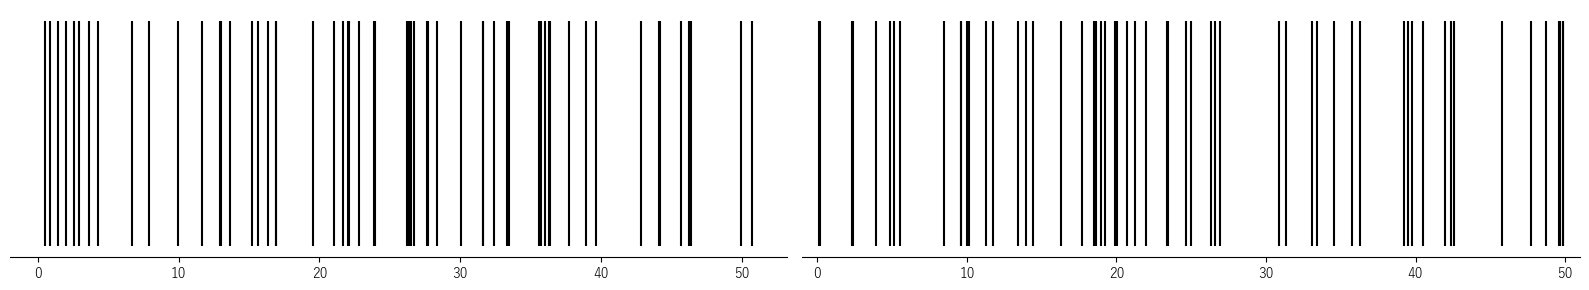

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)

for i, l in enumerate([1, 1.1]):
    ax = axes[i]
    ax.vlines(poisson_process(l, max_t=50), 0, 1)
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.xlim([-1, 51])
# plt.tick_params(left=False, right=False, top=False)
plt.tight_layout()

# plt.savefig('spoisson.png')
plt.show()

## 既存手法

- 教師なしOoD
	- 既存手法の多くは対数尤度ベース
	- 提案手法は、OoD検知とGoFテストを明確に区別している。これを区別できないと様々な問題が起きる可能性（Appendix.A）
	- 多くは画像だが、提案手法は可変長イベントシーケンス
- TPPの異常検知
	- 従来手法: 距離ベースのアプローチや敵対的学習
	- 提案手法は学習手順はそのままで、任意のTPPと組み合わせることができる
- **TPPに対する適合度検定(GoF)**
	- Kolmogorov-Smirnov検定やカイ二乗検定（時間変換定理と組み合わせて古くから使われている）
	- 提案手法3Sはイベント数Nへの依存性も考慮できる
	    - 実験的にもよい結果を示している
- **Sum-of-squared-spacings**
	- 似たような統計量は、古くは固定数の点がある区間内に一様に分布しているかを検定するために使用された。
	- 提案手法はNが不変ではないため、TPPにより適している

### K-S検定を利用したGoFテスト

- K-S検定？
    - 経験分布を帰無仮説において示された累積分布関数と比較する。主な応用は、正規分布および一様分布に関する適合度検定。[(wikipedia)](https://ja.wikipedia.org/wiki/コルモゴロフ–スミルノフ検定)
    - Qiitaとかみると正規性検定によく使われてる印象
- どうやってKS検定を使うか？
    - 時間変換定理が活躍
        - 適切なcompensator$\Lambda^*$ を作用させることで、強度1の定常ポアソン過程に変換可能
        - 強度1の定常ポアソン過程:
            - イベント時刻の配列: 一様分布
            - イベント間隔の配列: 指数分布
    - In-Distの$\Lambda^*$ をOoDデータに作用させ時間変換
        - KS検定量を計算すればOoD検知に使える
- 論文中で指摘する問題点
    - あくまでイベントが一様に分布してるかのみをチェックしている
    - ✖イベント数$N$を考慮できていない。

![](fig/ks_vs_3s.png)



## 基本的なアイデア
- In-Distなデータにおけるcompensatorを得る
- In-DistとOoDそれぞれについて、前述のcompensatorをもちいて時間変換を行う
    - 定理に基づけば、In-Distでは強度1の定常ポアソン過程に、OoDでは別の変換が行われるはず。
- 変換後のデータの統計量から適合度検定を行う。
    - 本論文ではこの検定のための新しい指標を提案

## 提案指標

Notation

- イベント数: $N$
- （可変）イベント長: $[0, T]$
- 観測イベントシーケンス: $X=(t_1, \cdots, t_N)$
- 条件付き強度関数: $\lambda^* (t)=\lambda(t|\mathcal H_t)$
- 累積強度関数（a.k.a compensator）: $\Lambda^*(t)=\int_0^t \lambda^*(u)du$
- イベント長: $[0, V]$
- 時間変換後のイベントシーケンス（定常ポアソン過程）: $Z=(v_1, \cdots, v_N)=(\Lambda^* (t_1), \cdots, \Lambda^* (t_N))$

**sum-of-squared-spacings (3S)**

$$
\psi(Z) = \frac{1}{V} \sum_{i=1}^{N+1} w^2_i = \frac{1}{V} \sum_{i=1}^{N+1} (v_i - v_{i-1})^2
$$

これを使ってGoFテストをすることを提案している（論文7式）。
直感的には、$N$固定の下で、
- 間隔が極めて不均一の時、$\psi$は最大される
	- ある間隔$w_i$だけとても大きいとき、$w_i\rightarrow V$なので$\psi \rightarrow V$
- 等間隔の時、最小
	- $w_1=\cdots=w_N=\frac{V}{N+1}$


## Summary
compensator $\Lambda^*$が既知のTPPのGoFテストは、観測系列$X$を時間変換し系列$Z$を得たのち、統計量$\psi(Z)$を計算する。帰無仮説$H_0$の下で統計量のCDFは解析的に計算できないため、$\mathbb P_{model}$からのサンプルで近似する。そこで、TPPから実現値$\mathcal{D}_{model}={X_1,\cdots, X_M}$ を持ってきて、$\mathcal D_{model}$の統計量をもつEDFを使って$X$に対する$p$値を計算する。

注: 学習済み生成モデル$\mathbb P_{model}$に対するGoFテストと提案手法のOoD検知は等価ではない。

## 実験
- In-Distributionなデータ: 強度1のポアソン過程
- OoDなデータ
    - 強度を大きくしたポアソン過程
    - 強度を小さくしたポアソン過程
    - 非定常ポアソン過程
    - 更新過程
    - Hawkes過程
    - Self-correcting過程

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import anomaly_tpp as tpp

from tqdm.auto import tqdm, trange
from statsmodels.distributions.empirical_distribution import ECDF

sns.set_style('whitegrid')
%matplotlib inline

In [5]:
num_sequences = 1000
t_max = 100
scenarios = [
    tpp.scenarios.spp.IncreasingRate(t_max),
    tpp.scenarios.spp.DecreasingRate(t_max),
    tpp.scenarios.spp.InhomogeneousPoisson(t_max),
    tpp.scenarios.spp.RenewalUp(t_max),
    tpp.scenarios.spp.RenewalDown(t_max),
    tpp.scenarios.spp.Hawkes(t_max),
    tpp.scenarios.spp.SelfCorrecting(t_max),
    tpp.scenarios.spp.Stopping(t_max),
]

test_statistics = [
    tpp.statistics.ks_arrival,
    tpp.statistics.ks_interevent,
    tpp.statistics.chi_squared,
    tpp.statistics.sum_of_squared_spacings,
]

### $H_0$でのそれぞれの検定統計量の分布を計算

In [6]:
model = tpp.models.StandardPoissonProcess()
# in-distribution (ID) training sequences are used to estimate the CDF of the test statistic under H_0
# (this is then used to compute the p-values)
# 何れのscenariosもStandardPoissonScenarioを継承しており、sample_id()で強度1の定常ポアソン過程に基づくデータセットを生成
id_train = scenarios[0].sample_id(num_sequences) # 1000個のイベントシーケンスを生成
id_train_batch = tpp.data.Batch.from_list(id_train) #
id_train_poisson_times = tpp.utils.extract_poisson_arrival_times(model, id_train_batch)

In [7]:
# Empirical distribution of each test statistic on id_train.
# This approximates the CDF of the test statistic under H_0
# and is used to compute the p-values
ecdfs = {}

for stat in test_statistics:
    name = stat.__name__
    scores = stat(poisson_times_per_mark=id_train_poisson_times)
    ecdfs[name] = ECDF(scores) # 経験分布関数はIn-Distのデータ（定常ポアソン過程に変換）を使用

def twosided_pval(stat_name: str, scores: np.ndarray):
    """Compute two-sided p-value for the given values of test statistic.

    Args:
        stat_name: Name of the test statistic,
            {"ks_arrival", "ks_interevent", "chi_squared", "sum_of_squared_spacings"}
        scores: Value of the statistic for each sample in the test set,
            shape [num_test_samples]

    Returns:
        p_vals: Two-sided p-value for each sample in the test set,
            shape [num_test_samples]
    """
    ecdf = ecdfs[stat_name](scores) # 事前計算したECDFに統計量を入力、両側検定量を得る
    return 2 * np.minimum(ecdf, 1 - ecdf)

### In-Sampleな系列データに対する検定統計量を計算

In [8]:
# ID test sequences will be compared to OOD test sequences to evaluate different test statistics
id_test = scenarios[0].sample_id(num_sequences)
id_test_batch = tpp.data.Batch.from_list(id_test)
id_test_poisson_times = tpp.utils.extract_poisson_arrival_times(model, id_test_batch)

# Compute the statistics for all ID test sequences
id_test_scores = {}
for stat in test_statistics:
    name = stat.__name__
    id_test_scores[name] = stat(poisson_times_per_mark=id_test_poisson_times)

### OODな系列データに対する検定統計量の計算 & p値に基づきAUC/ROCを評価

In [9]:
results = []

detectability_values = np.arange(0, 0.95, step=0.05) # ここでdetactabilityといっているのは、OOD点過程のパラメータ
num_seeds = 5
for seed in trange(num_seeds):
    for scenario in tqdm(scenarios):
        for det in detectability_values:
            np.random.seed(seed)
            ood_test = scenario.sample_ood(num_sequences=num_sequences, detectability=det)
            ood_test_batch = tpp.data.Batch.from_list(ood_test)
            ood_poisson_times_per_mark = tpp.utils.extract_poisson_arrival_times(model, ood_test_batch)

            for stat in test_statistics:
                stat_name = stat.__name__
                id_scores = id_test_scores[stat_name]
                id_pvals = twosided_pval(stat_name, id_scores)

                ood_scores = stat(poisson_times_per_mark=ood_poisson_times_per_mark)
                ood_pvals = twosided_pval(stat_name, ood_scores)

                auc = tpp.utils.roc_auc_from_pvals(id_pvals, ood_pvals)

                res = {"statistic": stat_name, "seed": seed, "detectability": det,
                       "auc": auc, "scenario": scenario.name}
                results.append(res)

# 結果のプロット
- 縦軸はAUC（大きいほど良い）
- 横軸はOoDデータを作成する際のハイパーパラメータ（大きいほど定常ポアソン過程から離れる）

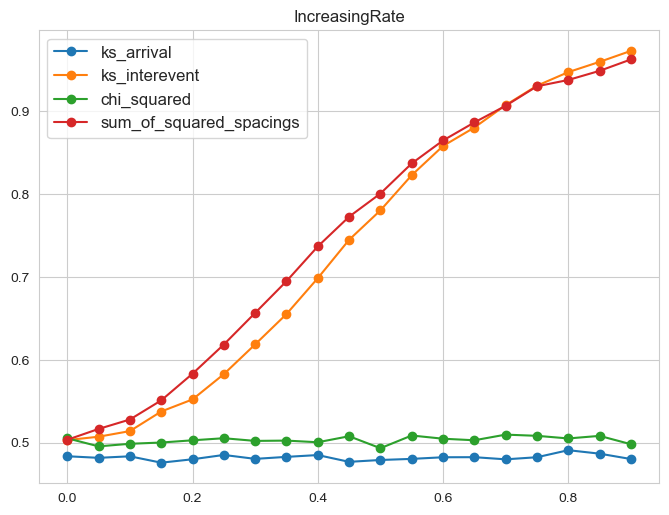

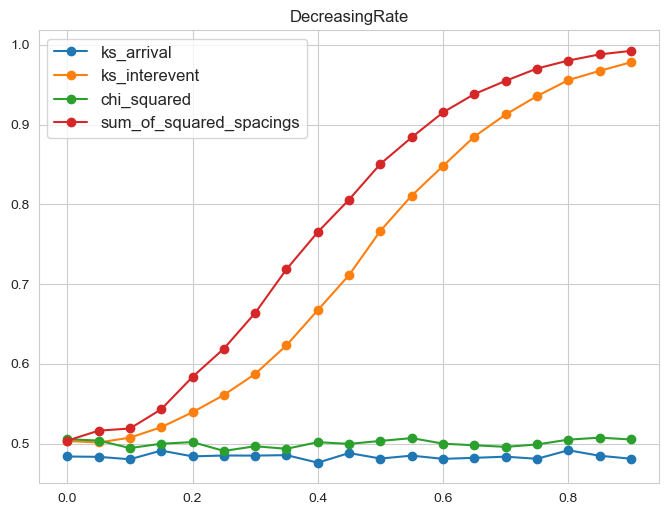

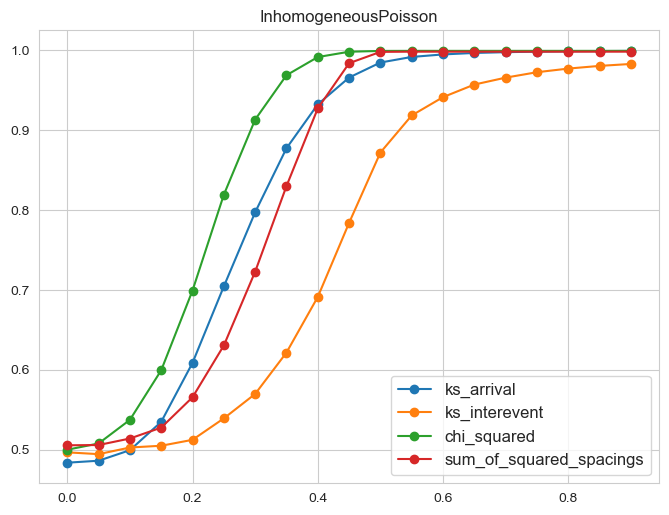

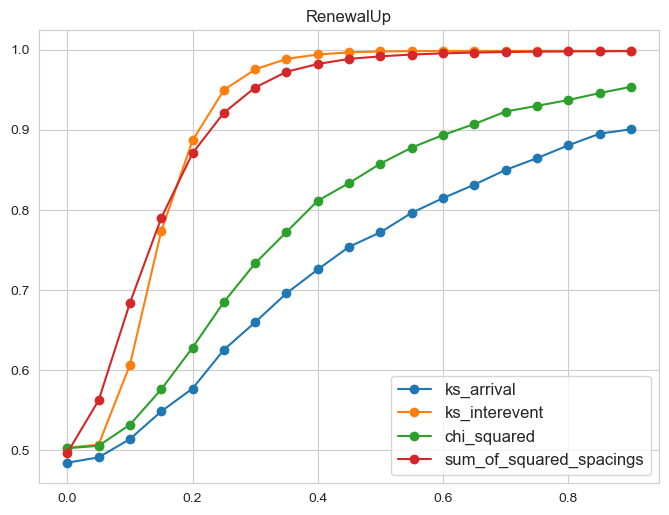

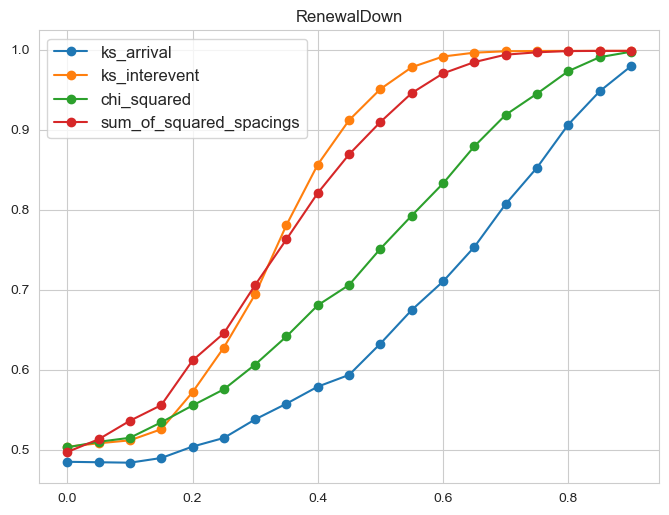

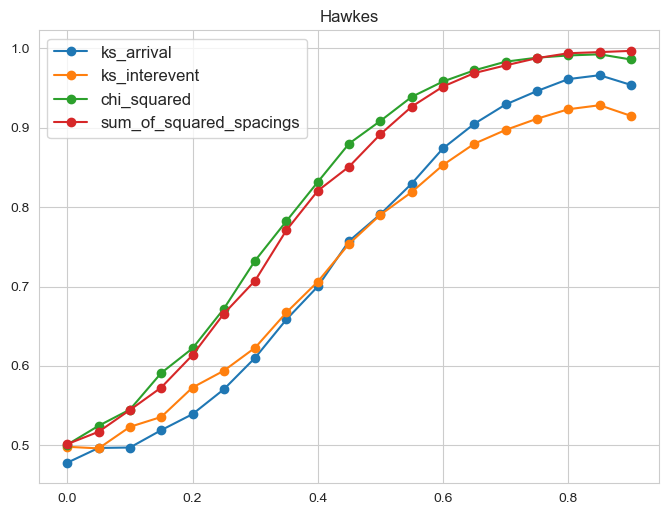

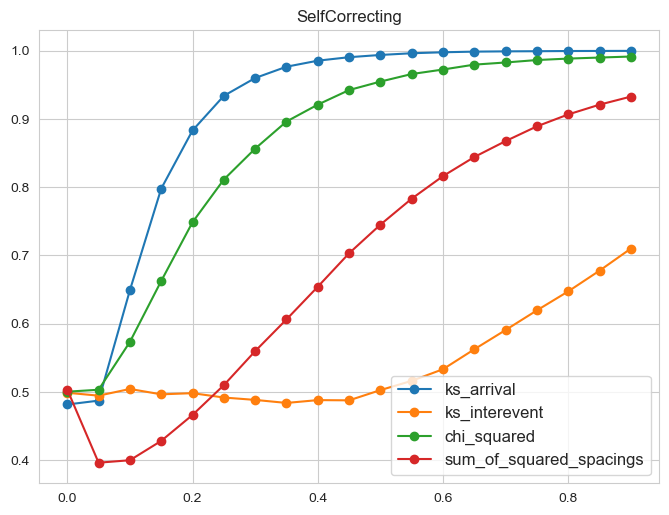

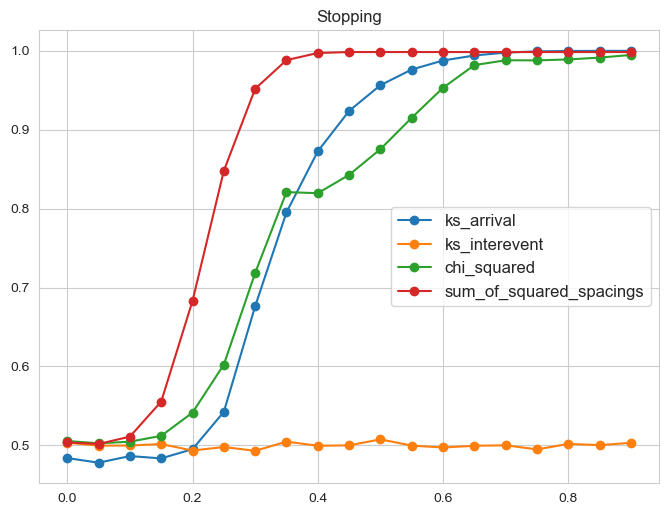

In [10]:
from matplotlib import ticker
df = pd.DataFrame(results)
for scen in df.scenario.unique():
    fig = plt.figure(figsize=[8, 6], dpi=100)
    ax = fig.add_subplot()
    df_sub = df[df.scenario == scen]
    _df = df_sub.groupby(['statistic', 'detectability']).mean()
    labels = df_sub['statistic'].unique()
    for label in labels:
        x = _df.loc[label].index
        y = _df.loc[label]['auc']
        ax.plot(x, y, label=label, marker='.', markersize=12)

    ax.set_title(scen)
    plt.legend(fontsize=12)
    plt.show()

plt.close('all')

## 多変量の場合

- 先ほどの実験はIn-Distが強度1の定常ポアソン過程で、compensatorがknownだった
- 多変量の実験では、compensatorが不明という過程で同様の実験を行う
    - compensatorの推定: Neural TPP
- いい結果が得られた


![](fig/Pasted_image_20211112170742.png)

## 実データの場合

- 実データでも同様にNeuralTPPでcompensatorを推定→時間変換の後、検定
- いい結果が得られた

![](fig/real_data.png)
